In [1]:
# Uncomment line below to install exlib
# !pip install exlib

In [2]:
import sys
sys.path.append("../../src")
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import exlib
from exlib.datasets.chestx import *
from exlib.features.vision import *

/home/antonxue/lib/miniconda3/envs/exlib/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Overview
* The objective is to predict the **pathology** regions (atelectasis, calcification, etc. Total 13).
* The higher-level features are the anatomical **structures** (left clavicle, right clavicle, etc. Total 14).

In [3]:
dataset = ChestXDataset(split="test")
pathols_model = ChestXPathologyModel().from_pretrained("BrachioLab/chestx_pathols").eval()

## Dataset samples and model predictions
Primary task: predict where the pathologies are

In [4]:
torch.manual_seed(105)
for i in torch.randperm(len(dataset)):
    sample = dataset[i.item()]
    image, pathols, structs = sample["image"], sample["pathols"], sample["structs"]
    if pathols.sum() > 0 and structs.sum() > 0:
        break

with torch.no_grad():
    pathols_pred = pathols_model(image[None,...])[0]

Atelectasis: 0.140
Cardiomegaly: 0.052
Consolidation: 0.358
Edema: 0.015
Effusion: 0.049
Emphysema: 0.500
Fibrosis: 0.504
Hernia: 0.260
Infiltration: 0.520
Mass: 0.059
Nodule: 0.509
Pleural_Thickening: 0.509
Pneumonia: 0.067
Pneumothorax: 0.044


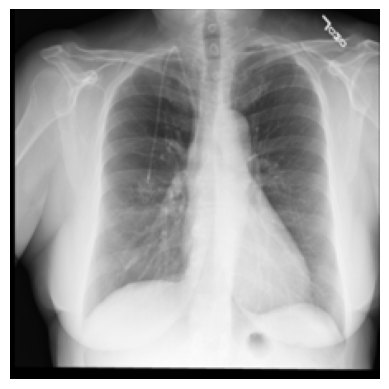

In [5]:
plt.clf()
plt.imshow(image.numpy().transpose(1,2,0), cmap="gray")
plt.axis("off")

for name, score in zip(dataset.pathology_names, pathols_pred):
    print(f"{name}: {score:.3f}")

## Expert-specified higher-level features: anatomical structures
Identifying where key structures are is important!

<Figure size 640x480 with 0 Axes>

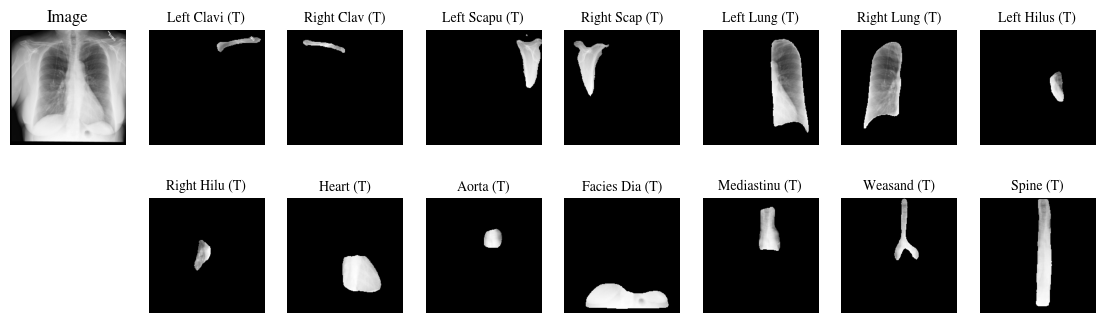

In [6]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    (["image"] + [f"struct{i}t" for i in range(7)]),
    (["."] + [f"struct{i}t" for i in range(7,14)]),
], figsize=(14,4))

for _, a in ax.items(): a.set_axis_off()
struct_titles = ChestXDataset.structure_names

ax["image"].imshow(image.numpy().transpose(1,2,0), cmap="gray")
ax["image"].set_title("Image")

for i in range(14):
    mask_t = structs[i].unsqueeze(0)
    ax[f"struct{i}t"].imshow(((image * mask_t).numpy().transpose(1,2,0)) * 2, cmap="gray")
    ax[f"struct{i}t"].set_title(f"{struct_titles[i][:10]} (T)", fontsize=10)

## How well are the higher-level feature alignments?

In [7]:
all_baseline_scores = get_chestx_scores(dataset=dataset, N=100, batch_size=4)

dataloader 25


100%|██████████████████████| 25/25 [08:54<00:00, 21.38s/it]


In [8]:
for name, scores in all_baseline_scores.items():
    print(f'BASELINE {name} mean score: {scores.nanmean()}')

BASELINE identity mean score: 0.21211296319961548
BASELINE random mean score: 0.04253542050719261
BASELINE patch mean score: 0.09955804795026779
BASELINE quickshift mean score: 0.3367842137813568
BASELINE watershed mean score: 0.14116907119750977
BASELINE sam mean score: 0.30522453784942627
BASELINE ace mean score: 0.2605726420879364
BASELINE craft mean score: 0.1197023093700409
BASELINE archipelago mean score: 0.2134942263364792
